# CONTENTS

Risk insurance strategies, starting with basic Constant Proportion Portfolio Insurance (CPPI) strategies, and moving on to more sophisticated strategies that aim at achieving the highest possible upside potential while imposing stringent limits to portfolio drawdown.

Monte-Carlo simulations techniques required for the proper backtesting of insurance strategies.

In [74]:
import Basic_Risk_Assessment_Tools as brat

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
%matplotlib inline
import copy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from nsetools import Nse
from nsepy import get_history

In [29]:
start_date = datetime.date(2009,1,1)
end_date = datetime.date.today()
nse_tickers = ["BAJAJHLDNG","NCC","OLECTRA"]
closing_prices, returns = brat.get_returns_from_close_as_dataframe(nse_tickers,start_date,end_date)

BAJAJHLDNG
done :)
NCC
done :)
OLECTRA
done :)


In [30]:
risky_assets = copy.deepcopy(returns)

In [31]:
brat.compare_timeseries_lengths(risky_assets)

,Start Date,End Date,Length
BAJAJHLDNG,2009-01-02,2020-07-07,2851
NCC,2009-01-02,2020-07-07,2851
OLECTRA,2009-01-02,2020-07-07,2680


In [32]:
risky_returns_df, cov_mat = brat.get_covariance_matrix(risky_assets)
risky_returns_df.reset_index(drop=True, inplace=True)
risky_returns_df

,BAJAJHLDNG,NCC,OLECTRA
0,0.032245,0.147119,-0.020050
1,0.032226,0.017730,0.002558
2,0.010343,0.061556,-0.012755
3,-0.056493,-0.216083,-0.051680
4,-0.030340,-0.175157,-0.019074
...,...,...,...
2672,0.010676,0.025729,-0.049587
2673,0.006303,0.026756,-0.017391
2674,-0.015408,-0.008143,0.007375
2675,0.042392,0.054187,-0.020498


In [54]:
safe_r = pd.DataFrame().reindex_like(risky_returns_df)
safe_r.values[:] = 0.03/260 # fast way to set all values to a number
start = 60000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value
safe_r.head()

,BAJAJHLDNG,NCC,OLECTRA
0,0.000115,0.000115,0.000115
1,0.000115,0.000115,0.000115
2,0.000115,0.000115,0.000115
3,0.000115,0.000115,0.000115
4,0.000115,0.000115,0.000115


Now, we need to backtest this strategy by starting at the beginning and at every point in time:

1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier)
3. Compute the new asset value

In [55]:
# set up the CPPI parameters
dates = risky_returns_df.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3     #the multiplier

## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_returns_df)
risky_w_history = pd.DataFrame().reindex_like(risky_returns_df)
cushion_history = pd.DataFrame().reindex_like(risky_returns_df)

cushion_history.head()

,BAJAJHLDNG,NCC,OLECTRA
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [56]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_returns_df.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_returns_df).cumprod()

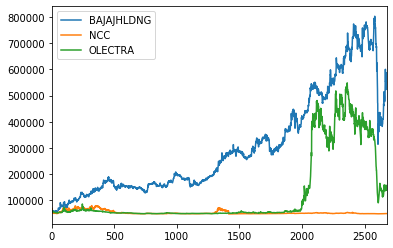

In [57]:
# Value of CPPI investment over time
account_history.plot()

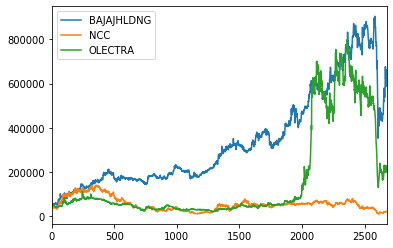

In [58]:
# Wealth due to compounding if money is put into risky asset  without CPPI
risky_wealth.plot()

For NCC, the benefits of CPPI are evident because when the value of the stock goes down from around x=500 to x=1300 the allocation to the risky asset goes down.

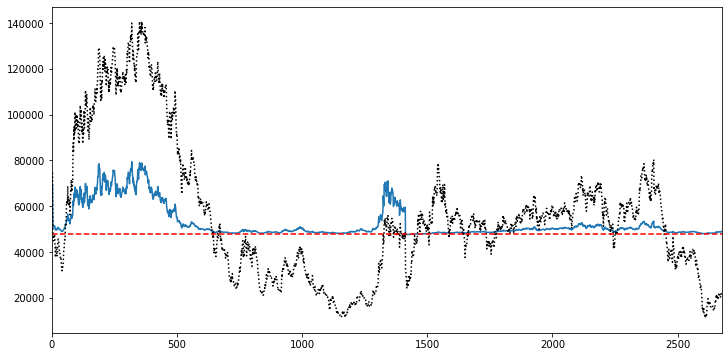

In [59]:
ax = account_history['NCC'].plot(figsize=(12,6),use_index=False)
risky_wealth['NCC'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

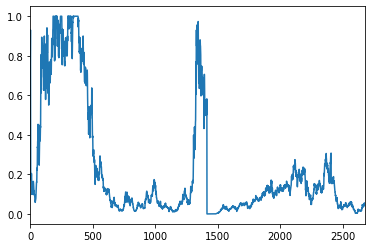

In [60]:
risky_w_history['NCC'].plot()

# Limitation of CPPI

For BAJAJHLDNG and OLECRTA we can see a limitation of the current implementation of CPPI. As the value of the investment increases the chances of it going below the constant floor 48,000 reduces to a very small fraction.

Therefore, even when the value of the stock plummets after x=2500, the allocation to the Risky Asset remains at 100% and we loose a lot of possible gains

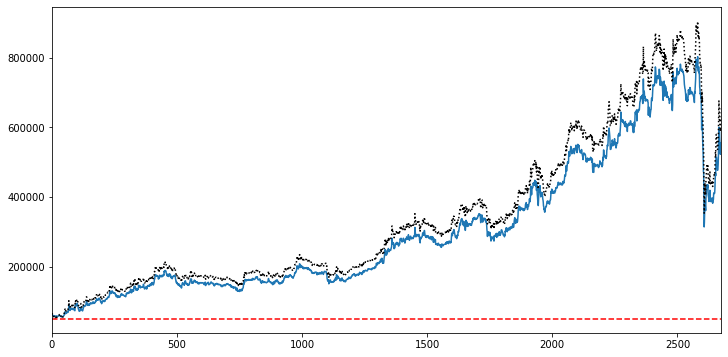

In [61]:
ax = account_history["BAJAJHLDNG"].plot(figsize=(12,6),use_index=False)
risky_wealth["BAJAJHLDNG"].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

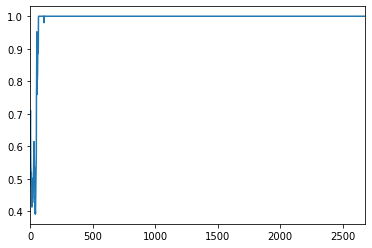

In [62]:
risky_w_history['BAJAJHLDNG'].plot()

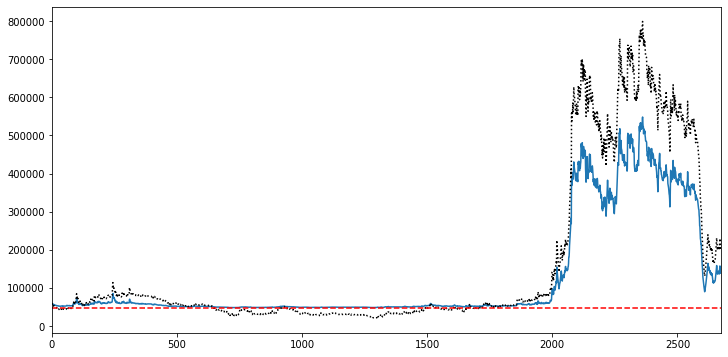

In [63]:
ax = account_history['OLECTRA'].plot(figsize=(12,6),use_index=False)
risky_wealth['OLECTRA'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

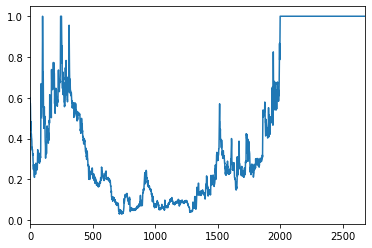

In [64]:
risky_w_history['OLECTRA'].plot()

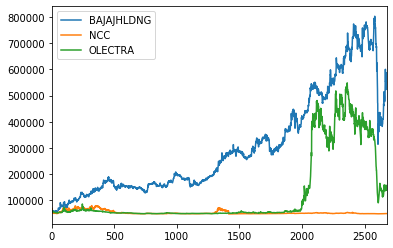

In [68]:
# Check if BRAT's CPPI function works

cppi_dict_without_dc = brat.cppi(risky_assets, start= 60000, risk_free_return=0.03, floor=0.80)
cppi_dict_without_dc["Wealth"].plot()

In [75]:
# a summary stats function to get a dataframe of all major stats for a set of returns

brat.summary_stats(risky_assets, riskfree_rate=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
BAJAJHLDNG,0.319748,0.250910,0.784711,0.603006,-60.922175,0.001058,0.000088,True,0.239291,12.194364,False,0.014081,0.031554,0.025305,0.042862,0.026541
NCC,0.591556,-0.070328,-0.118887,-0.217103,-91.571872,0.000394,-0.001255,True,0.170302,6.127153,False,0.023901,0.059940,0.053609,0.076746,0.051287
OLECTRA,0.551077,0.125931,0.228518,0.123088,-83.587427,0.001015,-0.000549,True,2.241684,18.340637,False,0.018132,0.055189,0.017543,0.061994,0.047513


In [83]:
# get the summary stats of the returns we get from cppi investment

cppi_returns = {
    "BAJAJHLDNG": pd.DataFrame(cppi_dict_without_dc['Wealth'].pct_change().dropna()["BAJAJHLDNG"], columns=["BAJAJHLDNG"]),
    "NCC": pd.DataFrame(cppi_dict_without_dc['Wealth'].pct_change().dropna()["NCC"], columns=["NCC"]),
    "OLECTRA": pd.DataFrame(cppi_dict_without_dc['Wealth'].pct_change().dropna()["OLECTRA"], columns=["OLECTRA"])
}
brat.summary_stats(cppi_returns, riskfree_rate=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
BAJAJHLDNG,0.314851,0.245665,0.780259,0.595728,-60.922175,0.001036,0.000153,True,0.167737,12.741604,False,0.013902,0.031076,0.025115,0.041898,0.026204
NCC,0.200930,-0.027535,-0.137038,-0.426193,-40.021273,-0.000028,0.000088,False,-2.658297,58.510937,False,0.012282,0.020521,0.013570,0.032066,0.014727
OLECTRA,0.389290,0.086958,0.223377,0.074131,-83.587427,0.000596,-0.000127,True,4.369245,61.620681,False,0.015258,0.039108,-0.029544,0.049128,0.033200


Comparing the Sharpe Ratio, Max Drawdown, Semi Deviation and the various VaR metrics of the original returns and the CPPI Investment returns, it is evident that the CPPI provides an improved performance even in adverse market conditions.

However, we will also notice that the impact on the maximum drawdown wasn't large in the case of BAJAJ HOLDING and OLECTRA because of the fact that the investment value was too large comapred to the floor value. As a result the CPPI algorithm didn't reduce the allocation towards the risky asset even though a lot of value was being lost after the x=2500 mark.

# Drawdown Constraint

As we saw in the case of BAJAJHLDNG and OLECTRA, when the value of the investment becomes too large, the chances of it breaching the floor reduce to near 0 values. Thus, a lot of potential profits are not realised because the shift to the safe asset was not triggered.

To prevent these extreme losses we can make the floor value dependent on the net value of the investment/unrealised gains. That way our profits can be further maximised.

We will do this by adding a DRAWDOWN CONSTRAINT which will keep increasing the value of the floor along with the wealth. 

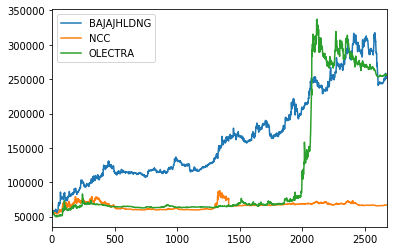

In [91]:
# Check if BRAT's CPPI function works along with the drawdown constraint

cppi_dict_with_dc = brat.cppi(risky_assets, start, risk_free_return=0.03, floor=0.80, drawdown_constraint=0.25)
cppi_dict_with_dc["Wealth"].plot()

We can see that the performance of the CPPI algorithm is improved when drawdown constraint is added and a variable floor is used.

In the case of NCC it even enables us to make a profit when we would have made a loss had we stuck to the simple risky asset investment or CPPI investment without Drawdown Constraint

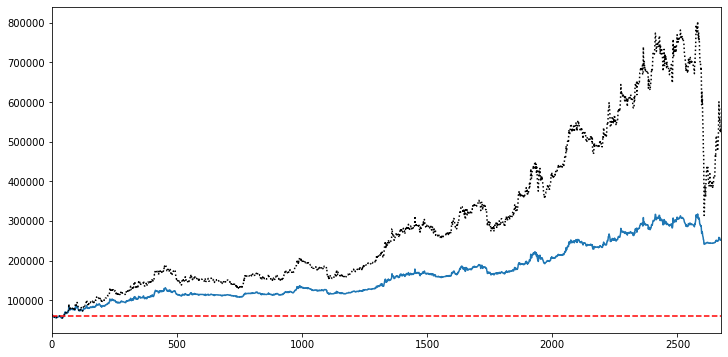

In [92]:
ax = cppi_dict_with_dc['Wealth']['BAJAJHLDNG'].plot(figsize=(12,6),use_index=False)
cppi_dict_without_dc['Wealth']['BAJAJHLDNG'].plot(ax=ax, style='k:')
ax.axhline(y=start, color='r', linestyle='--')

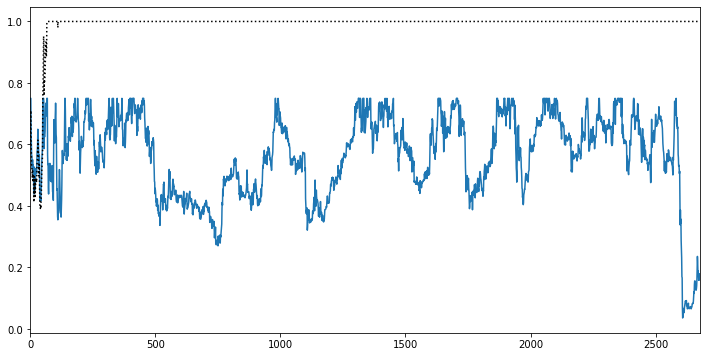

In [93]:
ax = cppi_dict_with_dc["Risky Allocation"]['BAJAJHLDNG'].plot(figsize=(12,6),use_index=False)
cppi_dict_without_dc["Risky Allocation"]['BAJAJHLDNG'].plot(ax=ax, style='k:')

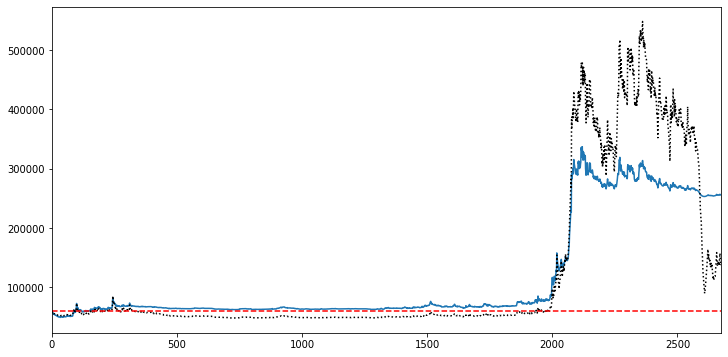

In [94]:
ax = cppi_dict_with_dc['Wealth']['OLECTRA'].plot(figsize=(12,6),use_index=False)
cppi_dict_without_dc['Wealth']['OLECTRA'].plot(ax=ax, style='k:')
ax.axhline(y=start, color='r', linestyle='--')

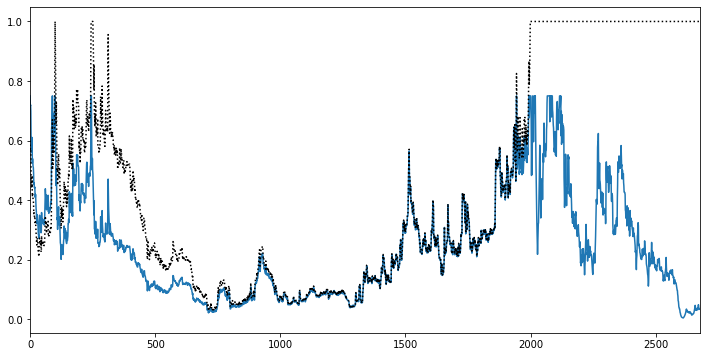

In [95]:
ax = cppi_dict_with_dc["Risky Allocation"]['OLECTRA'].plot(figsize=(12,6),use_index=False)
cppi_dict_without_dc["Risky Allocation"]['OLECTRA'].plot(ax=ax, style='k:')

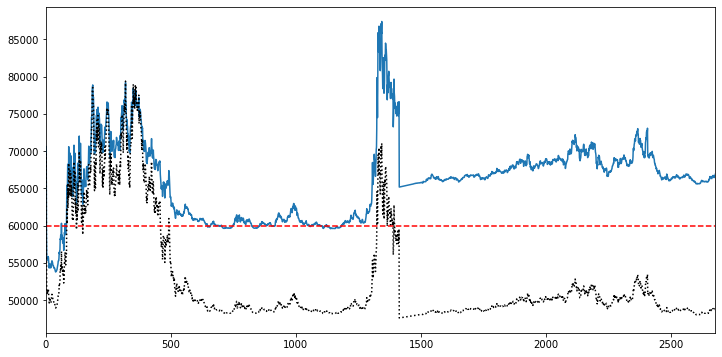

In [98]:
ax = cppi_dict_with_dc['Wealth']['NCC'].plot(figsize=(12,6),use_index=False)
cppi_dict_without_dc['Wealth']['NCC'].plot(ax=ax, style='k:')
ax.axhline(y=start, color='r', linestyle='--')

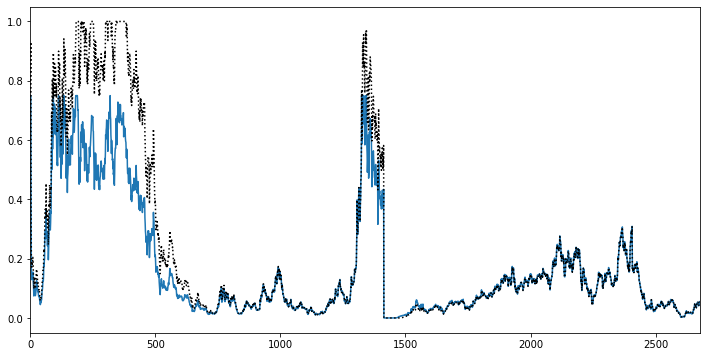

In [99]:
ax = cppi_dict_with_dc["Risky Allocation"]['NCC'].plot(figsize=(12,6),use_index=False)
cppi_dict_without_dc["Risky Allocation"]['NCC'].plot(ax=ax, style='k:')

In [100]:
# get the summary stats of the returns we get from cppi investment

cppi_returns = {
    "BAJAJHLDNG": pd.DataFrame(cppi_dict_without_dc['Wealth'].pct_change().dropna()["BAJAJHLDNG"], columns=["BAJAJHLDNG"]),
    "NCC": pd.DataFrame(cppi_dict_without_dc['Wealth'].pct_change().dropna()["NCC"], columns=["NCC"]),
    "OLECTRA": pd.DataFrame(cppi_dict_without_dc['Wealth'].pct_change().dropna()["OLECTRA"], columns=["OLECTRA"])
}
brat.summary_stats(cppi_returns, riskfree_rate=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
BAJAJHLDNG,0.314851,0.245665,0.780259,0.595728,-60.922175,0.001036,0.000153,True,0.167737,12.741604,False,0.013902,0.031076,0.025115,0.041898,0.026204
NCC,0.200930,-0.027535,-0.137038,-0.426193,-40.021273,-0.000028,0.000088,False,-2.658297,58.510937,False,0.012282,0.020521,0.013570,0.032066,0.014727
OLECTRA,0.389290,0.086958,0.223377,0.074131,-83.587427,0.000596,-0.000127,True,4.369245,61.620681,False,0.015258,0.039108,-0.029544,0.049128,0.033200


In [102]:
# get the summary stats of the returns we get from cppi investment

cppi_returns_wiht_dd = {
    "BAJAJHLDNG": pd.DataFrame(cppi_dict_with_dc['Wealth'].pct_change().dropna()["BAJAJHLDNG"], columns=["BAJAJHLDNG"]),
    "NCC": pd.DataFrame(cppi_dict_with_dc['Wealth'].pct_change().dropna()["NCC"], columns=["NCC"]),
    "OLECTRA": pd.DataFrame(cppi_dict_with_dc['Wealth'].pct_change().dropna()["OLECTRA"], columns=["OLECTRA"])
}
brat.summary_stats(cppi_returns_wiht_dd, riskfree_rate=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
BAJAJHLDNG,0.178592,0.149007,0.834341,0.509019,-24.092392,0.000595,0.000138,True,1.228452,15.289150,False,0.007403,0.017620,0.010022,0.023806,0.015566
NCC,0.153399,0.000392,0.002556,-0.376194,-25.419701,0.000048,0.000063,False,-2.396647,67.745951,False,0.009172,0.015598,0.008047,0.023195,0.010081
OLECTRA,0.223342,0.153033,0.685199,0.425059,-24.899066,0.000638,-0.000004,True,7.068807,118.180842,False,0.007776,0.022140,-0.051712,0.024141,0.012497


Comparing the Sharpe Ratio, Max Drawdown, Semi Deviation and the various VaR metrics of the CPPI Investment returns without Drawdown Constraint to the one with it, it is evident that the DRWADOWN CONSTRAIN provides an improvement in the portfolio performance.